In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

# Read in and process data

Define what csv files to use

In [2]:
# # cellpose_file = "../cellpose_results/cellpose_run04_240427113411.csv"
# # cellpose_file = "../cellpose_results/cellpose_run04_240501153104.csv"
# cellpose_file = "../cellpose_results/cellpose_run05_240527232502.csv"
# cellpose_file = "../cellpose_results/cellpose_run06_240601015117.csv"
cellpose_file = "../cellpose_results/cellpose_run07_240712134610.csv"
# # food_file = "../FoodSeg103_results/food_run04_240428133857.csv"
# # food_file = "../FoodSeg103_results/food_run04_240501155333.csv"
# food_file = "../FoodSeg103_results/food_run05_240531110123.csv"
# food_file = "../FoodSeg103_results/food_run06_240531234417.csv"
food_file = "../FoodSeg103_results/food_run07_240711113239.csv"

Load raw dataframes and process them

In [3]:
# Load the dataframes from the csv files
cellpose_df = pd.read_csv(cellpose_file)
# food_df = pd.read_csv(food_file)

dfs = [cellpose_df]
# For each metric, add additional infos/columns
for df in dfs:
    for metric in ['accuracy', 'mIoU', 'mPrecision', 'mRecall', 'mF1']:
        for scr in df['scribbles'].unique():
            
            # Add a column for the improvement over the ilastik prediction
            perf_il = df.loc[(df['scribbles'] == scr) & (df['prediction tag'] == "ilastik"), metric].values[0]
            df.loc[(df['scribbles'] == scr), f'{metric}_impr_to_ilastik'] = df.loc[(df['scribbles'] == scr), metric] - perf_il

            # Add a column stating which model of each prediciton type is best (especially interesting for convpaint)
            scr_df = df.loc[df['scribbles'] == scr]
            for pred_type in scr_df['prediction type'].unique():
                pred_type_df = scr_df[scr_df['prediction type'] == pred_type]
                best_idx = pred_type_df[metric].idxmax()
                df.loc[best_idx, f"best_{metric}"] = df.loc[best_idx, "prediction tag"]
    # Replace NA by blanks
    df.fillna("", inplace=True)

# Show the dataframes
for df in dfs:
    # Show shape, the first rows and the mean values for each scribbles bin
    print(df.shape)
    print(df.columns)
    # display(df[:15])
    # display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

(75600, 38)
Index(['img_num', 'prediction tag', 'prediction type', 'layers', 'scalings',
       'scribbles mode', 'scribbles bin', 'suffix', 'class_1_pix_gt',
       'class_2_pix_gt', 'min_class_pix_gt', 'max_class_pix_gt',
       'pix_labelled', 'class_1_pix_labelled', 'class_2_pix_labelled',
       'min_class_pix_labelled', 'max_class_pix_labelled', 'pix_in_img',
       'perc. labelled', 'accuracy', 'mPrecision', 'mRecall', 'mIoU', 'mF1',
       'image', 'ground truth', 'scribbles', 'prediction',
       'accuracy_impr_to_ilastik', 'best_accuracy', 'mIoU_impr_to_ilastik',
       'best_mIoU', 'mPrecision_impr_to_ilastik', 'best_mPrecision',
       'mRecall_impr_to_ilastik', 'best_mRecall', 'mF1_impr_to_ilastik',
       'best_mF1'],
      dtype='object')


Save processed dataframes to csv files

In [4]:
cellpose_df.to_csv(f'{cellpose_file[:-4]}_processed.csv', index=False)
# food_df.to_csv(f'{food_file[:-4]}_processed.csv', index=False)

Load already processed dataframes from the csv files

In [5]:
cellpose_df = pd.read_csv(f'{cellpose_file[:-4]}_processed.csv')
food_df = pd.read_csv(f'{food_file[:-4]}_processed.csv')
# cellpose_df.fillna("-", inplace=True)
# food_df.fillna("-", inplace=True)

for df in [cellpose_df, food_df]:
    # Show shape, the first rows and the mean values for each scribbles bin
    print(df.shape)
    # display(df[:15])
    display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

(75600, 38)


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.010,0.007990,14.737037,0.762355
0.025,0.020697,38.285185,0.790426
0.050,0.043617,80.861111,0.834474
0.100,0.091388,169.290741,0.853468
0.250,0.238859,440.588889,0.873558
0.500,0.485618,894.625926,0.885084
1.000,0.979729,1802.866667,0.893139
2.500,2.449240,4505.262963,0.903122
5.000,4.841458,8897.888889,0.910989


(72800, 32)


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.010,0.008690,15.500000,0.607728
0.025,0.022307,39.584615,0.652707
0.050,0.044698,78.934615,0.677246
0.100,0.090498,160.761538,0.713481
0.250,0.227867,403.101923,0.765757
0.500,0.449823,793.932692,0.803203
1.000,0.898720,1592.111538,0.847292
2.500,2.306416,4090.367308,0.894020
5.000,4.633788,8187.111538,0.917673


# Choose performance METRIC and DATASET

In [6]:
# metric = "accuracy"
# metric = "mPrecision"
# metric = "mRecall"
metric = "mIoU"
# metric = "mF1"

In [7]:
use_for_all = "cellpose"
# use_for_all = "food"

# Inspect the dataset

### Check for extreme cases by sorting

Examples: best cases for certain model, or worst performance compared to Ilastik

In [8]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[df_filtered['layers'] == 0]
# df_filtered = df_filtered[df_filtered['scalings'] == 1]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# List the 10 cases where convpaint performs the worst compared to ilastik
df_filtered.sort_values(by=f'{metric}_impr_to_ilastik', ascending=True)[0:10][['img_num', 'accuracy', 'accuracy_impr_to_ilastik', 'scribbles bin', 'perc. labelled', 'pix_in_img', 'min_class_pix_gt']]

,img_num,accuracy,accuracy_impr_to_ilastik,scribbles bin,perc. labelled,pix_in_img,min_class_pix_gt
13161,94,0.308206,-0.522250,0.010,0.007500,160000,77693
53915,385,0.528279,-0.444177,0.025,0.021943,414720,15976
14001,100,0.410375,-0.417220,0.010,0.008889,202500,81266
14141,101,0.298909,-0.486938,0.010,0.006914,202500,75026
40321,288,0.356228,-0.426342,0.010,0.008011,262144,103310
8541,61,0.037604,-0.755049,0.010,0.007139,196096,10646
8289,59,0.824943,-0.163879,0.050,0.044366,196096,16806
25481,182,0.470769,-0.340109,0.010,0.008669,196096,35475
60117,429,0.626541,-0.267583,0.250,0.238345,160272,41627
39901,285,0.611163,-0.231192,0.010,0.007610,157696,75421


### Check distribution of performance among the dataset

In [9]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

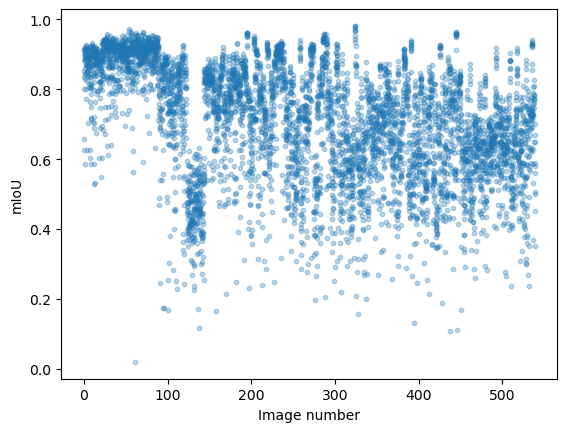

In [10]:
# Plot
plt.scatter(df_filtered['img_num'], df_filtered[metric], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel(metric)
plt.show()

# Check distribution of the _improvements over Ilastik_ among the dataset

In [11]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 0.1)]

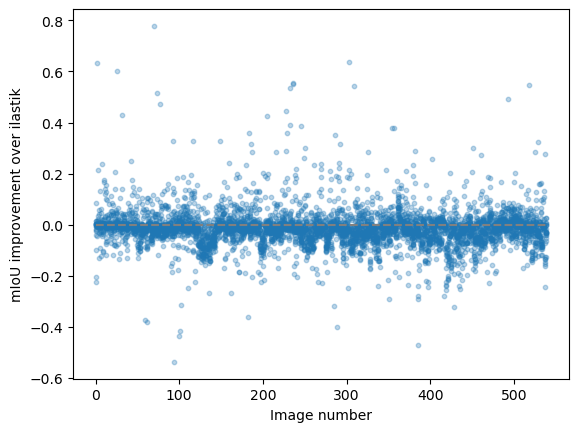

In [12]:
# Plot
plt.scatter(x = df_filtered['img_num'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel(f'{metric} improvement over ilastik')
plt.hlines(0, np.min(df_filtered['img_num']), np.max(df_filtered['img_num']), colors='grey', linestyles='dashed')
plt.show()

### Correlation between pixels labelled and improvement

Cellpose: Pixels labelled in one or the other class (not working for FoodSeg103 with multiple classes)

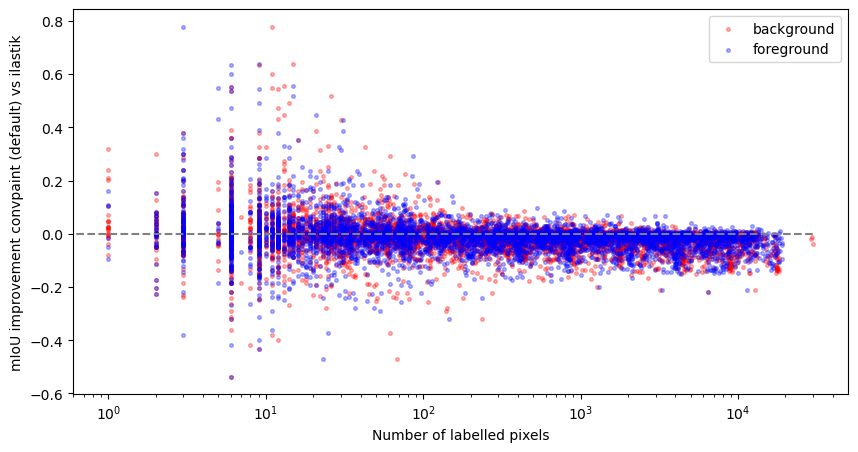

In [13]:
if use_for_all == "cellpose":
    # Define which dataframe to use
    df = cellpose_df.copy()

    # Optionally filter the dataframe
    df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
    # df_filtered = df_filtered[(df['scribbles bin'] == 1)]

    # Plot
    plt.figure(figsize=(10, 5), dpi=100)
    plt.scatter(df_filtered["class_1_pix_labelled"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=7, c="red", label="background")
    plt.scatter(df_filtered["class_2_pix_labelled"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=7, c = "blue", label="foreground")
    plt.xlabel("Number of labelled pixels")
    plt.xscale("log")
    plt.hlines(0, 0, np.max([np.max(df_filtered["class_1_pix_labelled"]), np.max(df_filtered["class_1_pix_labelled"])]), colors='grey', linestyles='dashed')
    plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
    plt.legend()
    plt.show()
else:
    print("Plot only available for cellpose data")

Minimum/maximum pixels labelled among classes

In [14]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

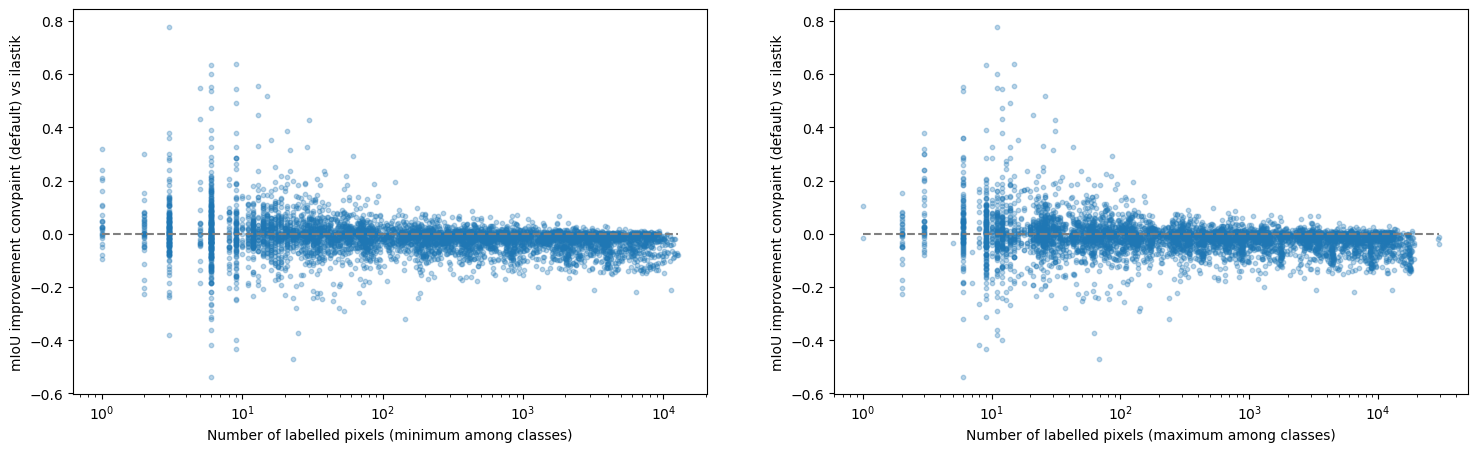

In [15]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
ax1.scatter(x = df_filtered['min_class_pix_labelled'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
ax1.set_xlabel("Number of labelled pixels (minimum among classes)")
ax1.set_xscale("log")
ax1.hlines(0, np.min(df_filtered['min_class_pix_labelled']), np.max(df_filtered['min_class_pix_labelled']), colors='grey', linestyles='dashed')
ax1.set_ylabel(f'{metric} improvement convpaint (default) vs ilastik')
ax2.scatter(x = df_filtered['max_class_pix_labelled'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
ax2.set_xlabel("Number of labelled pixels (maximum among classes)")
ax2.set_xscale("log")
ax2.hlines(0, np.min(df_filtered['max_class_pix_labelled']), np.max(df_filtered['max_class_pix_labelled']), colors='grey', linestyles='dashed')
ax2.set_ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.show()

### Correlation between the resolution (# pixels) and the improvement

In [16]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 0.1)]

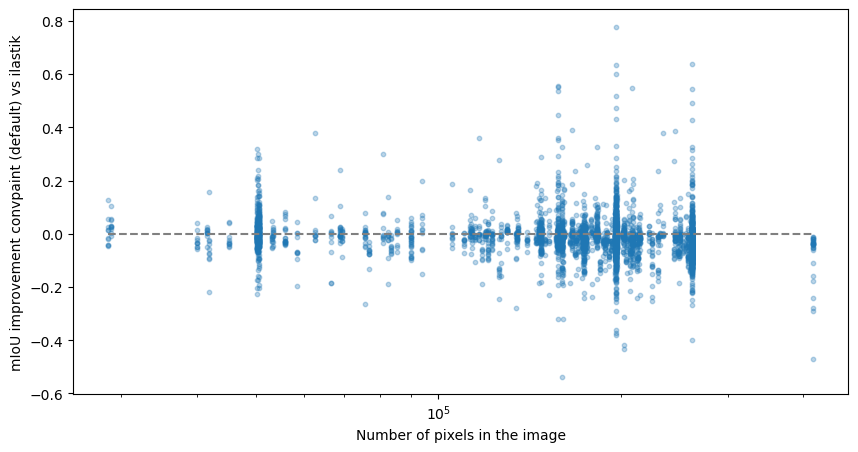

In [17]:
# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_filtered["pix_in_img"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
plt.xlabel("Number of pixels in the image")
plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.hlines(0, np.min(df_filtered["pix_in_img"]), np.max(df_filtered["pix_in_img"]), colors='grey', linestyles='dashed')
plt.xscale("log")
plt.show()

# Compare bins

### Improvement over Ilastik

In [18]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df
df_filtered = df_filtered[df_filtered['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[df_filtered[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
bins_to_use = [0.025, 0.5, 10]; df_filtered = df_filtered[df_filtered['scribbles bin'].isin(bins_to_use)]

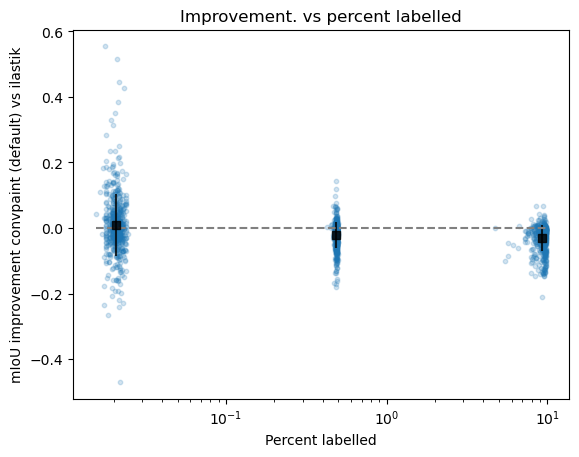

In [19]:
# Plot
plt.scatter(df_filtered['perc. labelled'], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.2, s=10)
df_grouped = df_filtered.groupby('scribbles bin').agg({f'{metric}_impr_to_ilastik': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[f'{metric}_impr_to_ilastik']['mean'], yerr=df_grouped[f'{metric}_impr_to_ilastik']['std'], fmt='s', c='black', alpha=0.8)
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.hlines(0, np.min(df_filtered['perc. labelled']), np.max(df_filtered['perc. labelled']), colors='grey', linestyles='dashed')
plt.title('Improvement. vs percent labelled')
plt.show()

### Performance of different models on separate dotplots side-by-side

In [20]:
def plot_perf_vs_perc_labelled(df, pred_to_show="convpaint", plt_ax=None, **kwargs):
    if plt_ax is None:
        plt_ax = plt.subplots(1, 1)[1]
    
    if pred_to_show:
        df_exact = df[df['prediction tag'] == pred_to_show]
        if len(df_exact) == 0:
            df_filtered = df[df['prediction tag'].str.contains(pred_to_show)]
        else:
            df_filtered = df_exact

    # Scatterplot
    plt_ax.scatter(df_filtered['perc. labelled'], df_filtered[metric], alpha=0.2, s=10, **kwargs)

    # Grouped plot
    df_grouped = df_filtered.groupby('scribbles bin').agg({metric: ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
    plt_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='black', alpha=0.8)
    plt_ax.set_xscale('log')
    plt_ax.set_ylim(0, 1)
    # plt_ax.set_xticks([0.05, 0.1, 1])
    plt_ax.set_xlabel('Percent labelled')
    plt_ax.set_ylabel(metric)
    plt_ax.set_title(f'{metric} vs percent labelled {pred_to_show}')

In [21]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Which convpaint model to use and compare to ilastik and dino (if using use_best, we do not filter a specific model)
convpaint_model = 'convpaint_l-0_s-1-2'
use_best = False

# Optionally filter the dataframe
df_filtered = df
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
bins_to_use = [0.025, 0.5, 10]; df_filtered = df_filtered[df_filtered['scribbles bin'].isin(bins_to_use)]

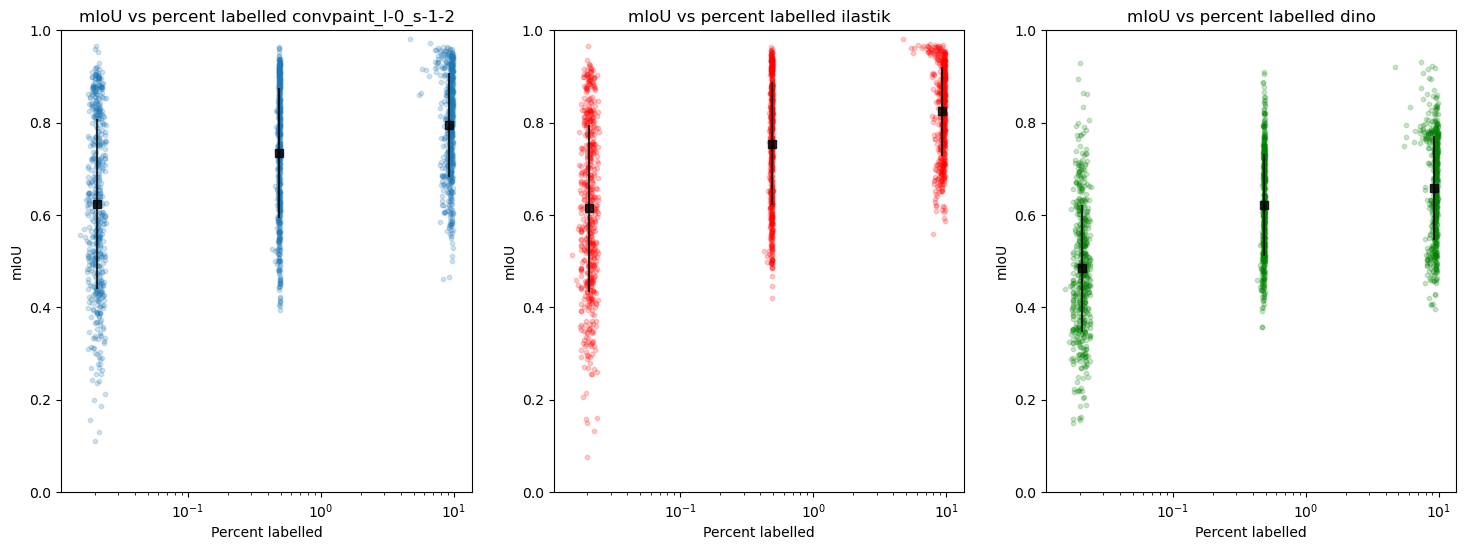

In [22]:
# Filter the predictions to show
if use_best:   
    df_filtered = df_filtered[df_filtered[f'best_{metric}'].str.len()>1]
    convpaint_model = "convpaint"
pred_tag_1 = convpaint_model
pred_tag_2 = 'ilastik'
pred_tag_3 = 'dino'


# Plot
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.set_dpi(100)
plot_perf_vs_perc_labelled(df_filtered, pred_tag_1, plt_ax=ax[0])
plot_perf_vs_perc_labelled(df_filtered, pred_tag_2, plt_ax=ax[1], c='red')
plot_perf_vs_perc_labelled(df_filtered, pred_tag_3, plt_ax=ax[2], c='green')

# plt.savefig(f'{cellpose_file[:-4]}_{metric}-vs-labels.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_{metric}-vs-labels.pdf', dpi=300)
plt.show()

### Performance of different models on same dotplot

In [23]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Which convpaint model to use and compare to ilastik and dino (if using use_best, we do not filter a specific model)
convpaint_model = 'convpaint_l-0_s-1-2'
use_best = False

# Optionally filter the dataframe
df_filtered = df
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
bins_to_use = [0.025, 0.5, 10]; df_filtered = df_filtered[df_filtered['scribbles bin'].isin(bins_to_use)]

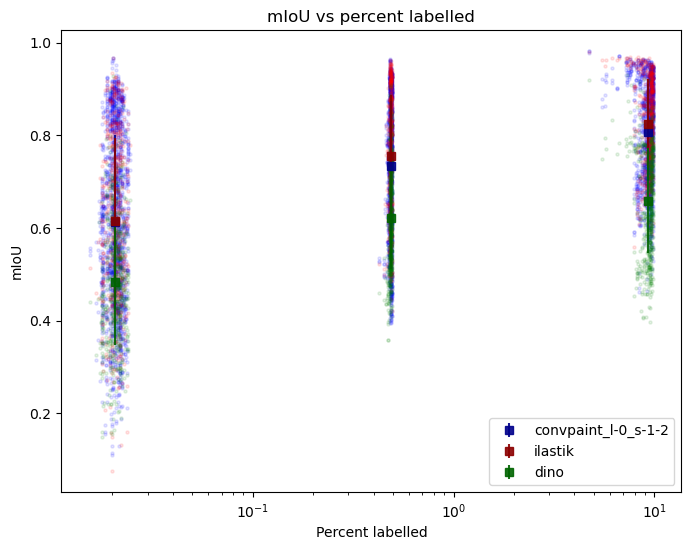

In [24]:
# Filter the predictions to show
if use_best:   
    df_filtered = df_filtered[df_filtered[f'best_{metric}'].str.len()>1]
    convpaint_model = "convpaint"
pred_tag_1 = convpaint_model
pred_tag_2 = 'ilastik'
pred_tag_3 = 'dino'

df_filtered_1 = df_filtered[df_filtered['prediction tag'].str.contains(pred_tag_1)]
df_filtered_2 = df_filtered[df_filtered['prediction tag'].str.contains(pred_tag_2)]
df_filtered_3 = df_filtered[df_filtered['prediction tag'].str.contains(pred_tag_3)]

# Plot performance vs percent labelled
plt.figure(figsize=(8,6),dpi=100)

# ADD FIRST PLOT
# Scatterplot
plt.scatter(df_filtered_1['perc. labelled'], df_filtered_1[metric], alpha=0.1, s=5, c='blue')
# Grouped plot
df_grouped = df_filtered_1.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkblue', alpha=0.9, label=pred_tag_1)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='blue', alpha=0.9)

# ADD SECOND PLOT
# Scatterplot
plt.scatter(df_filtered_2['perc. labelled'], df_filtered_2[metric], alpha=0.1, s=5, c='red')
# Grouped plot
df_grouped = df_filtered_2.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkred', alpha=0.9, label=pred_tag_2)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADD THIRD PLOT
# Scatterplot
plt.scatter(df_filtered_3['perc. labelled'], df_filtered_3[metric], alpha=0.1, s=5, c='green')
# Grouped plot
df_grouped = df_filtered_3.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkgreen', alpha=0.9, label=pred_tag_3)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADJUST PARAMETERS
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel(metric)
plt.title(f'{metric} vs percent labelled')
plt.legend()
plt.show()

### VIOLINPLOT (performance vs. percent labelled)

In [25]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Which models to compare; for convpaint, we can also use the best model (then we do not filter a specific model)
pred_tag_1 = 'convpaint_l-0_s-1-2'
use_best = False
pred_tag_2 = 'ilastik'

# Optionally filter the dataframe
df_filtered = df
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 1)] #& (df_filtered['scribbles bin'] < 10)]
bins_to_use = [0.025, 0.5, 10]; df_filtered = df_filtered[df_filtered['scribbles bin'].isin(bins_to_use)]

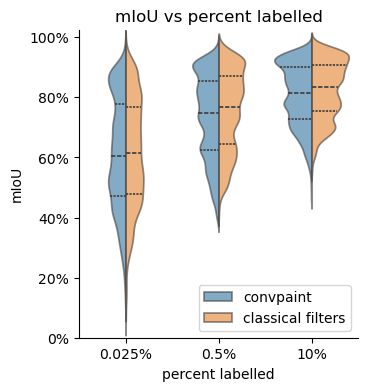

In [26]:
# Filter the predictions to show
if use_best:   
    df_filtered = df_filtered[df_filtered[f'best_{metric}'].str.len()>1]
    pred_tag_1 = "convpaint"
# Filter for the predicitons to use
df_filtered_1 = df_filtered[df_filtered['prediction tag'].str.contains(pred_tag_1)]
df_filtered_2 = df_filtered[df_filtered['prediction tag'].str.contains(pred_tag_2)]
df_both = pd.concat([df_filtered_1, df_filtered_2])

# Plot performance vs percent labelled (violin plot)
num_bins = len(df_filtered['scribbles bin'].unique())
plt.figure(figsize=(num_bins * 1.2, 4), dpi=100)

# Create the violin plot
ax = sns.violinplot(x='scribbles bin', y=metric, data=df_both, hue='prediction type', split=True, alpha=0.6, inner="quart", bw_adjust=0.65)

# Create line plot
# Group the bins
df_filtered_1_grouped = df_filtered_1.groupby('scribbles bin').agg({metric: 'median'}).reset_index()
df_filtered_2_grouped = df_filtered_2.groupby('scribbles bin').agg({metric: 'median'}).reset_index()
# Plot the means of each bin and connect them with a line
x_positions = ax.get_xticks()
# plt.plot(x_positions, df_filtered_1_grouped[metric], color='lightblue', alpha=0.8)
# plt.plot(x_positions, df_filtered_2_grouped[metric], color='orange', alpha=0.7)
# original colours: lightblue, orange

# Set some parameters
x_labels = [f"{int(x) if int(x)==x else x}%" for x in df_filtered_1_grouped['scribbles bin']]

plt.ylim(0, 1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_positions, x_labels)
plt.yticks(np.arange(0,1.1,0.2), [f"{int(x*100)}%" for x in np.arange(0,1.1,0.2)])
plt.legend(loc='lower right')
plt.xlabel('percent labelled')
plt.ylabel(metric)
plt.title(f'{metric} vs percent labelled')

# Show or save the plot
# plt.savefig(f'{cellpose_file[:-4]}_{metric}-vs-labels_convpaint-vs-ilastik.pdf", format='pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_{metric}-vs-labels_convpaint-vs-ilastik.pdf", format='pdf', dpi=300)
plt.show()

# Compare VGG16 layer/scaling combos

In [50]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

show_perc = False

# Optionally filter before comparing prediciton types (not for models, but e.g. for scribbles bins)
df_filtered = df
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
bins_to_use = [0.025, 0.5, 10]; df_filtered = df_filtered[df_filtered['scribbles bin'].isin(bins_to_use)]

In [51]:
# Split df for different bins
annot_bins = df_filtered['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

# Create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction tag'].str.contains('convpaint')] for single_bin_df in bin_df_list]
bin_df_list_ila = [single_bin_df[single_bin_df['prediction tag'].str.contains('ilastik')] for single_bin_df in bin_df_list]
bin_df_list_dino = [single_bin_df[single_bin_df['prediction tag'].str.contains('dino')] for single_bin_df in bin_df_list]

In [52]:
# Check if the list is composed as intended
# bin_df_list_conv[-1][bin_df_list_conv[-1]['img_num'] == 0]

In [53]:
# For a single bin:
# ylims = [0.4, 1]

# plt.figure(figsize=(4, 5), dpi=300)
# sns.lineplot(x='layers', y=metric, data=bin_df_list_conv[0], hue='scalings', palette='Blues', errorbar='sd', marker='o')
# plt.axhline(bin_df_list_ila[0][metric].mean(), color='red', linestyle='--', alpha=0.5)
# plt.axhline(bin_df_list_dino[0][metric].mean(), color='red', linestyle='--', alpha=0.5)

# # Hide y axis label of right plot
# plt.title(f"{annot_bins[0]}% annotation", fontsize=14)
# plt.ylim(ylims[0], ylims[1])
# plt.legend(loc='center').remove()

# # Use percentage if wanted
# plt.yticks(np.arange(ylims[0], ylims[1]+0.01, 0.1), [f"{x:.0%}" for x in np.arange(ylims[0], ylims[1]+0.01, 0.1)])

# plt.tight_layout()

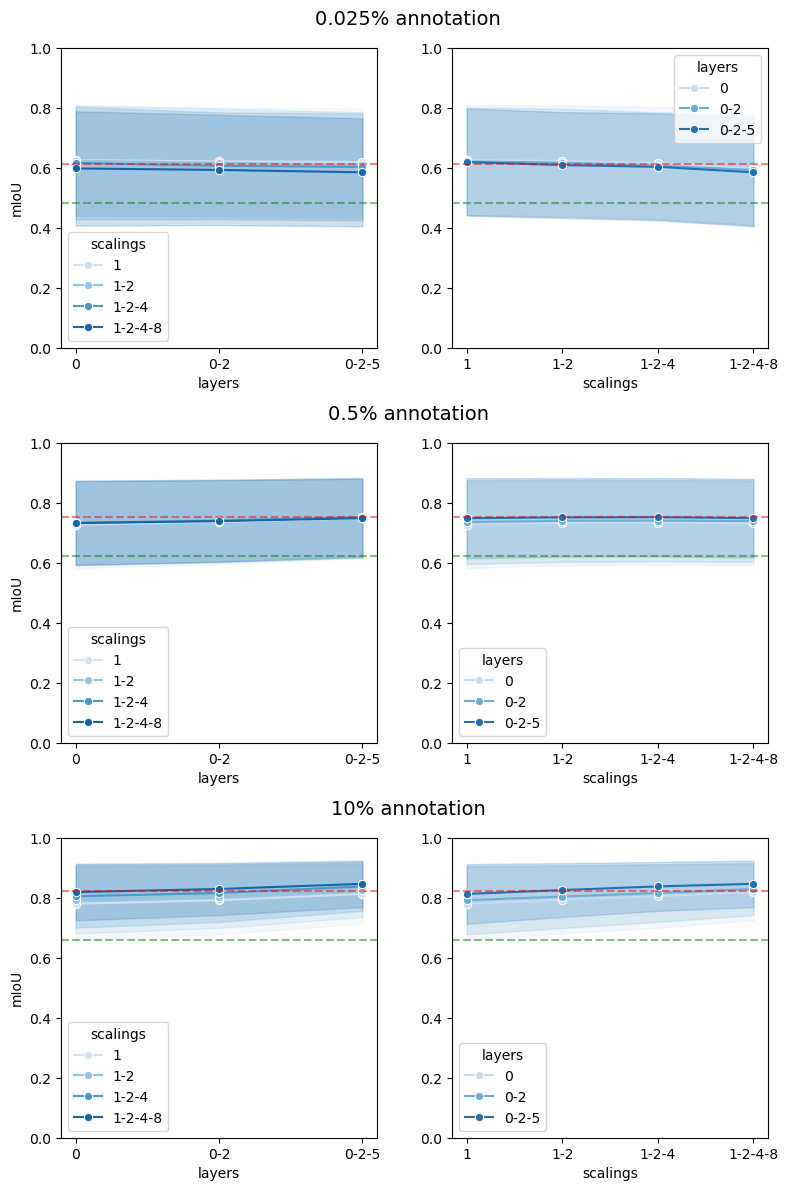

In [54]:
# Plot
num_df = len(bin_df_list_conv)
ylims = [0, 1]
fig, ax = plt.subplots(num_df, 2)
# ax = np.array([ax]) # If we have only 1 df, we need to convert the ax to a 2D array

fig.set_size_inches(8, 4 * num_df)
fig.set_dpi(100)

for i, df in enumerate(bin_df_list_conv):
    row = ax[i]
    sns.lineplot(x='layers', y=metric, data=df, hue='scalings', palette='Blues', errorbar='sd', marker='o',ax=row[0])
    row[0].axhline(bin_df_list_ila[i][metric].mean(), color='red', linestyle='--', alpha=0.5)
    row[0].axhline(bin_df_list_dino[i][metric].mean(), color='green', linestyle='--', alpha=0.5)
    sns.lineplot(x='scalings', y=metric, data=df, hue='layers', palette='Blues', errorbar='sd', marker='o',ax=row[1])
    row[1].axhline(bin_df_list_ila[i][metric].mean(), color='red', linestyle='--', alpha=0.5)
    row[1].axhline(bin_df_list_dino[i][metric].mean(), color='green', linestyle='--', alpha=0.5)

    # Hide y axis label of right plot
    row[0].set_title(f"{annot_bins[i]}% annotation", fontsize=14, x=1.1, y=1.05)
    row[1].set_ylabel('')
    # if i != num_df-1:
    #     row[0].set_xlabel('')
    #     row[1].set_xlabel('')
    row[0].set_ylim(ylims[0], ylims[1])
    row[1].set_ylim(ylims[0], ylims[1])

    # Use percentage if wanted
    if show_perc:
        for sub in row: sub.set_yticks(np.arange(ylims[0], ylims[1]+0.01, 0.1), [f"{x:.0%}" for x in np.arange(ylims[0], ylims[1]+0.01, 0.1)])
fig.tight_layout()
plt.show()

### Correlation between image resolution and effect of VGG16 scalings

In [55]:
# Choose the parameter to use for comparison
param_to_use = 'scalings'
params_to_comp = ['1-2-4-8', '1']
# param_to_use = 'layers'
# params_to_comp = ['0-2-5', '0']

In [56]:
grouped_dfs = []
for df_conv_bin in bin_df_list_conv:
    # df_conv_bin = df_conv_bin[df_conv_bin['layers']=='0']
    # Group by 'img_num' and 'scalings'/'layers' to compute average performance metric
    grouped_df = df_conv_bin.groupby(['img_num', f'{param_to_use}'])[metric].mean().unstack()
    grouped_df['img_num'] = grouped_df.index
    grouped_df['pix_in_img'] = df_conv_bin.groupby('img_num')['pix_in_img'].first().values
    grouped_df[f'{metric}_diff'] = grouped_df[params_to_comp[0]] - grouped_df[params_to_comp[1]]
    grouped_dfs.append(grouped_df)
# Display the result
grouped_dfs[0][:4]

scalings,1,1-2,1-2-4,1-2-4-8,img_num,pix_in_img,mIoU_diff
img_num,,,,,,,
0,0.647324,0.667056,0.689137,0.563500,0,196096,-0.083823
1,0.587237,0.594849,0.594590,0.577542,1,196096,-0.009695
2,0.804832,0.794608,0.809165,0.786933,2,196096,-0.017899
3,0.900913,0.897757,0.874563,0.859779,3,196096,-0.041134


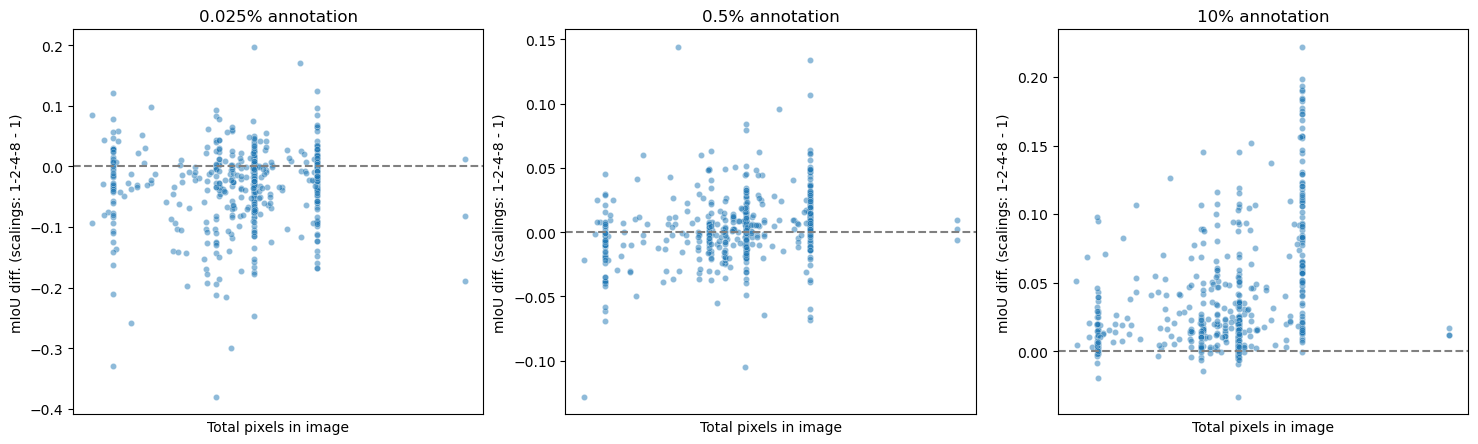

In [57]:
num_cols = int(np.ceil(num_df/2)) if num_df > 3 else num_df
num_rows = 2 if num_df > 3 else 1
fig, ax = plt.subplots(num_rows, num_cols)
ax = np.array([ax]) # If we have only 1 df, we need to convert the ax to a 2D array
ax = ax.flatten()
fig.set_size_inches(6*num_cols, 5*num_rows)
fig.set_dpi(100)
for i, grouped_df in enumerate(grouped_dfs):
    curr_ax = ax[i]
    sns.scatterplot(x='pix_in_img', y=f'{metric}_diff', data=grouped_df, s=20, alpha=0.5, ax=curr_ax)
    # curr_ax.set_xscale('log')
    # curr_ax.set_yscale('log')
    curr_ax.axhline(0, color='grey', linestyle='--')
    curr_ax.set_xticks([])    
    curr_ax.set_xlabel('Total pixels in image')
    curr_ax.set_ylabel(f'{metric} diff. ({param_to_use}: {params_to_comp[0]} - {params_to_comp[1]})')
    curr_ax.set_title(f'{annot_bins[i]}% annotation')
plt.show()

# HEATMAPS for model comparison

### Different ConvPaint models (layers/scaling combinations)

In [58]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

show_perc = False

# Optionally filter before comparing prediciton types (e.g. for scribbles bins)
df_filtered = df
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
bins_to_use = [0.025, 0.5, 10]; df_filtered = df_filtered[df_filtered['scribbles bin'].isin(bins_to_use)]

In [59]:
# Take only convpaint predictions
df_filtered = df_filtered[df_filtered['prediction tag'].str.contains('convpaint')]

# Split df for different bins
annot_bins = df_filtered['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df_filtered[df_filtered['scribbles bin'] == bin] for bin in annot_bins]
bin_df_list_conv = bin_df_list

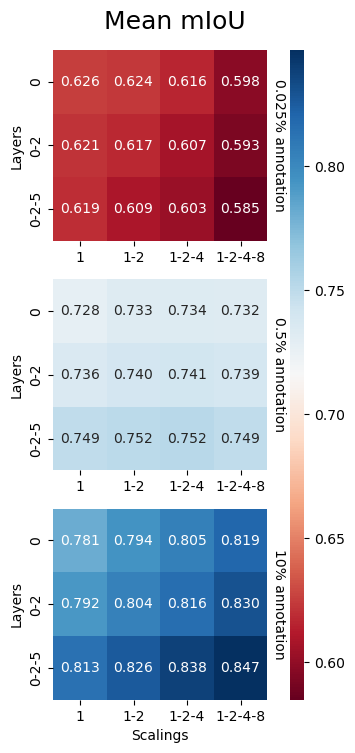

In [60]:
num_bins = len(annot_bins)
str_format = ".1%" if show_perc else ".3f"
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])
axis_matrix = [[str(bin), 'cbar'] for bin in annot_bins]
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [15, 1]})
ax_list = [ax[str(bin)] for bin in annot_bins]

unit = 18
title_height = 4 * 0.2
plot_height = title_height + (1 + 12 * num_bins) * 0.2 # title + bottom + plot per bin
plot_width = unit * (18) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'Mean {metric}', fontsize=18, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

for i, df in enumerate(bin_df_list_conv):
    row = ax_list[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values=metric)
    sns.heatmap(heatmap_df_mean, annot=True, cmap="RdBu", fmt=str_format, cbar=i==0, cbar_ax=ax['cbar'], ax=row, vmin=min_val, vmax=max_val)
    row.text(1.02, 0.5, f'{annot_bins[i]}% annotation', transform=row.transAxes, rotation=270, va='center')
    row.set_xlabel('Scalings' if i == num_bins - 1 else '')
    row.set_ylabel('Layers')

    # row.set_aspect('auto')

# When using precentage, also change the cbar
if show_perc:
    cbar_ticks = np.arange(min_val, max_val+0.0199, 0.02)
    ax['cbar'].set_yticks(cbar_ticks, [f"{x:.1%}" for x in cbar_ticks])

# plt.savefig(f'{cellpose_file[:-4]}_avg_{metric}_heatmap_convpaint.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_avg_{metric}_heatmap_convpaint.pdf', dpi=300)
plt.show()

### Convpaint models vs. Ilastik and DINOv2

In [61]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

show_perc = False

# Optionally filter the dataframe
df_filtered = df
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
bins_to_use = [0.025, 0.5, 10]; df_filtered = df_filtered[df_filtered['scribbles bin'].isin(bins_to_use)]

In [62]:
# Split df for different bins
annot_bins = df_filtered['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df_filtered[df_filtered['scribbles bin'] == bin] for bin in annot_bins]

# For each model, create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction tag'].str.contains('convpaint')] for single_bin_df in bin_df_list]
bin_df_list_ilastik = [single_bin_df[single_bin_df['prediction tag'].str.contains('ilastik')] for single_bin_df in bin_df_list]
bin_df_list_dino = [single_bin_df[single_bin_df['prediction tag'].str.contains('dino')] for single_bin_df in bin_df_list]

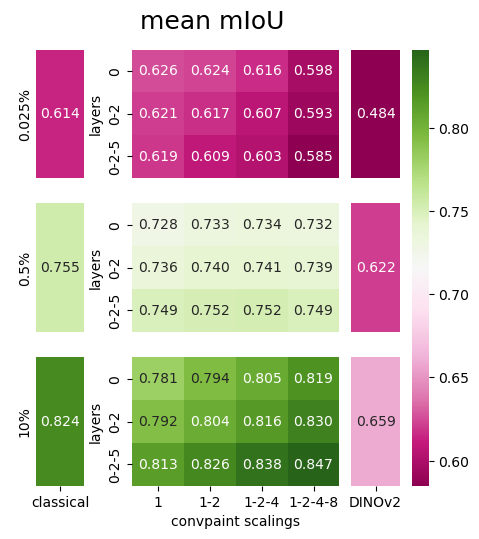

In [63]:
plot_metric = metric
str_format = ".1%" if show_perc else ".3f"
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])
# plot_metric = f"{metric}_impr_to_ilastik"
# min_val = -0.05#min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
# max_val = 0.05 #max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])

num_bins = len(annot_bins)
axis_matrix = np.array([['pad left', 
                          str(bin)+'ilastik', 
                          'pad', 
                          str(bin)+'convpaint', 
                          str(bin)+'dino', 
                          'cbar'] for bin in annot_bins])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [1, 3.5, 1.7, 15, 3.5, 1.2]})
for pad in ['pad left', 'pad']: ax[pad].axis('off')

unit = 18
title_height = 4 * 0.2
plot_height = title_height + (1 + 8 * num_bins) * 0.2 # title + bottom + plot per bin
plot_width = unit * (30) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'mean {plot_metric}', fontsize=unit, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

heatmap_cfg = {"annot":True, "cmap":"PiYG", "fmt":str_format if show_perc else ".3f", "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}
# original cmap = 'YlGnBu'; good alternatives: twilight_shifted, RdBu, PuBuGn, PuBu, BuGn, PiYG

# CONVPAINT
ax_list_conv = [ax[ax_idx] for ax_idx in axis_matrix[:,3]]#[ax['upper left'], ax['mid left'], ax['lower left']]
for i, df in enumerate(bin_df_list_conv):
    row = ax_list_conv[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values=plot_metric)
    sns.heatmap(heatmap_df_mean, cbar=i==0, ax=row, **heatmap_cfg)

    row.set_xlabel('convpaint scalings' if i == num_bins - 1 else '')
    if not i == num_bins - 1: row.set_xticks([])
    row.set_ylabel('layers')

# ILASTIK
ax_list_ila = [ax[ax_idx] for ax_idx in axis_matrix[:,1]] #[ax['upper mid'], ax['mid mid'], ax['lower mid']]
for i, df in enumerate(bin_df_list_ilastik):
    row = ax_list_ila[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df[plot_metric].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["classical"])
    else:
        row.set_xticks([])
    row.set_yticks([])
    row.text(-0.37, 0.5, f'{annot_bins[i]}%', transform=row.transAxes, rotation=90, va='center')

# DINOv2
ax_list_dino = [ax[ax_idx] for ax_idx in axis_matrix[:,4]]
for i, df in enumerate(bin_df_list_dino):
    row = ax_list_dino[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df[plot_metric].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["DINOv2"])
    else:
        row.set_xticks([])
    row.set_yticks([])

# When using precentage, also change the cbar
if show_perc:
    cbar_ticks = np.arange(min_val, max_val+0.0199, 0.04)
    ax['cbar'].set_yticks(cbar_ticks, [f"{x:.1%}" for x in cbar_ticks])

# plt.savefig(f'{cellpose_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
plt.show()

## Create heatmap with BEST models

In [64]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

show_perc = False

# Take only the best predictions
df = df[df[f'best_{metric}'].str.len() > 1]

# Optionally filter the dataframe
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
bins_to_use = [0.025,0.5, 10]
df = df[df['scribbles bin'].isin(bins_to_use)]

In [65]:
# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

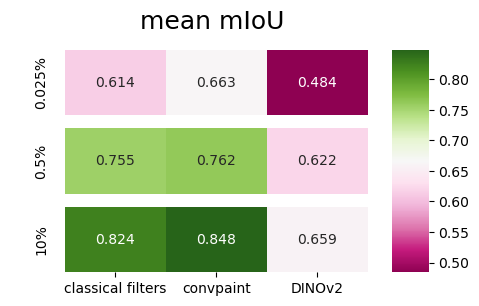

In [66]:
num_bins = len(annot_bins)
plot_metric = metric
str_format = ".1%" if show_perc else ".3f"
min_val = min([bin_df.pivot_table(columns='prediction type', values=metric).min().min() for bin_df in bin_df_list])
max_val = max([bin_df.pivot_table(columns='prediction type', values=metric).max().max() for bin_df in bin_df_list])

axis_matrix = np.array([['pad left', 
                          str(bin)+'heatmap', 
                          'cbar'] for bin in annot_bins])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [1, 10, 1.2]})
ax_list = [ax[ax_idx] for ax_idx in axis_matrix[:,1]]
ax['pad left'].axis('off')

unit = 18
title_height = 4 * 0.2
plot_height = title_height + (1 + 4 * num_bins) * 0.2 # title + bottom + plot per bin
plot_width = unit * (30) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'mean {plot_metric}', fontsize=unit, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))

heatmap_cfg = {"annot":True, "cmap":"PiYG", "fmt":str_format, "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}

for i, df in enumerate(bin_df_list):
    row = ax_list[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(columns='prediction type', values=plot_metric)[['classical filters', 'convpaint', 'DINOv2']]
    sns.heatmap(heatmap_df_mean, cbar=i==0, ax=row, **heatmap_cfg)

    row.set_xlabel('')
    if not i == num_bins - 1: row.set_xticks([])
    row.set_yticks([])
    row.text(-0.1, 0.5, f'{annot_bins[i]}%', transform=row.transAxes, rotation=90, va='center')

# When using precentage, also change the cbar
if show_perc:
    cbar_ticks = np.arange(min_val, max_val+0.0199, 0.04)
    ax['cbar'].set_yticks(cbar_ticks, [f"{x:.1%}" for x in cbar_ticks])

# Plot Computation Times

Load dataframes from csv files (different to the performance measures)

In [67]:
cellpose_time_file = "../cellpose_results/cellpose_time_prelim1.csv"
food_time_file = "../FoodSeg103_results/food_time_prelim1.csv"

In [68]:
cellpose_time_df = pd.read_csv(cellpose_time_file)
food_time_df = pd.read_csv(food_time_file)

Choose which data to plot and filter for convpaint, ilastik and dino to split the data

In [69]:
time_df = cellpose_time_df.copy()
# time_df = food_time_df.copy()
# time_df = {"cellpose": cellpose_time_df.copy(), "food": food_time_df.copy()}[use_for_all]

In [70]:
time_df_conv = time_df[time_df['prediction type'] == 'convpaint']
time_df_ilastik = time_df[time_df['prediction type'] == 'classical filters']
time_df_dino = time_df[time_df['prediction type'] == 'DINOv2']

In [71]:
time_df.groupby(['prediction type','layers', 'scalings']).agg({"t_features": "mean", "t_pred": "mean", "t_tot": "mean"}).round(2)

t_features  t_pred  t_tot
prediction type   layers scalings                           
DINOv2            -      -               2.20    0.48   2.67
classical filters -      -               0.38    0.81   1.20
convpaint         0      1               0.04    1.22   1.38
                         1-2             0.06    1.35   1.69
                         1-2-4           0.10    1.32   1.81
                         1-2-4-8         0.11    1.27   1.85
                  0-2    1               0.22    1.22   1.63
                         1-2             0.33    1.61   2.48
                         1-2-4           0.42    2.06   3.34
                         1-2-4-8         0.44    2.36   4.04
                  0-2-5  1               0.48    1.82   2.92
                         1-2             0.64    2.32   4.06
                         1-2-4           0.72    2.89   5.48
                         1-2-4-8         0.86    4.50   7.38

Plot the heatmaps

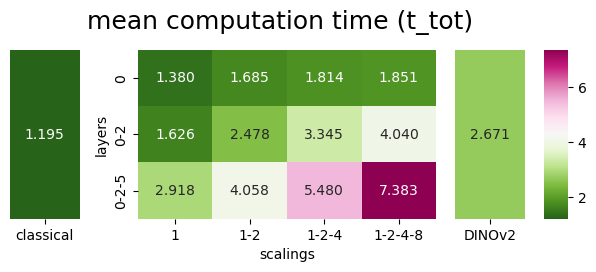

In [72]:
time_to_use = "t_tot"
heatmap_df_mean_conv = time_df_conv.pivot_table(index='layers', columns='scalings', values=time_to_use)
heatmap_df_mean_ila = time_df_ilastik[time_to_use].mean().reshape((1,1))
heatmap_df_mean_dino = time_df_dino[time_to_use].mean().reshape((1,1))

axis_matrix = np.array([['ilastik', 
                         'pad',
                         'convpaint', 
                         'dino', 
                         'cbar']])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [3.5, 1, 15, 3.5, 1.2]})

unit = 18
title_height = 4 * 0.2
plot_height = title_height + 10 * 0.2 # title + bottom + plot per bin
plot_width = unit * (40) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'mean computation time ({time_to_use})', fontsize=unit, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))

# fig.set_size_inches(8, 4)
# fig.set_dpi(100)

min_val = min([heatmap_df_mean_conv.min().min(), heatmap_df_mean_ila, heatmap_df_mean_dino])
max_val = max([heatmap_df_mean_conv.max().max(), heatmap_df_mean_ila, heatmap_df_mean_dino])
# If we want to have classical filters centered:
# max_dist_to_classical = max(abs(heatmap_df_mean_ila - min_val), abs(max_val - heatmap_df_mean_ila))
# min_val = heatmap_df_mean_ila - max_dist_to_classical
# max_val = heatmap_df_mean_ila + max_dist_to_classical
heatmap_cfg = {"annot":True, "cmap":"PiYG_r", "fmt":".3f", "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}
# original cmap = 'YlGnBu'; good alternatives: twilight_shifted, RdBu, PuBuGn, PuBu, BuGn, PiYG

# PLOT
sns.heatmap(heatmap_df_mean_conv, cbar=True, ax=ax['convpaint'], **heatmap_cfg)
sns.heatmap(heatmap_df_mean_ila, cbar=True, ax=ax['ilastik'], **heatmap_cfg)
sns.heatmap(heatmap_df_mean_dino, cbar=True, ax=ax['dino'], **heatmap_cfg)

ax["ilastik"].set_xticklabels(["classical"])
ax["ilastik"].set_yticks([])
ax["dino"].set_xticklabels(["DINOv2"])
ax["dino"].set_yticks([])
ax['pad'].axis('off')

# plt.savefig(f'{cellpose_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
plt.show()